# 1st Order Quality Check of DAS Data

This script should do a 1st ordder quality check of the DAS data. That means, that it will look for potential data gaps, recording issues, data saturation, etc... \
@Dominik: Activate the h5 mamba environment on Dominik's MacBook Pro for running this script.

In [416]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd

In [417]:
def sintela_to_datetime(sintela_times):
    '''
    returns an array of datetime.datetime 
    ''' 
    days1970 = datetime.date(1970, 1, 1).toordinal()

    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda )
    
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)
    
    return thisDateTime

In [418]:
files = glob.glob('../../../data/lab/*h5')
files.sort()
files

['../../../data/lab/decimator_2023-05-17_17.42.24_UTC.h5',
 '../../../data/lab/decimator_2023-05-18_23.04.34_UTC.h5']

In [419]:
import time
t0 = time.time()
f = h5py.File(files[-2],'r')
data = np.array(f['Acquisition/Raw[0]/RawData'])
attrs=dict(f['Acquisition'].attrs)
times = sintela_to_datetime(np.array(f['Acquisition/Raw[0]/RawDataTime']))
print(time.time()-t0)

1.295295238494873


Text(0.5, 0, 'Time [UTC]')

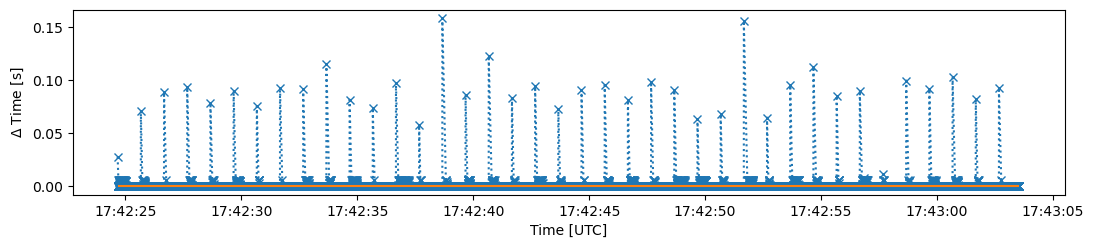

In [420]:
# time difference between samples
import scipy
dt = np.diff(np.array(f['Acquisition/Raw[0]/RawDataTime']))/1e6
fig = plt.figure(figsize=(6.4*2,4.8/2.))
plt.plot(times[:-1], dt, linestyle='dotted', marker='x')
plt.hlines(1/attrs['PulseRate'], times[0], times[-1], color='C1')
plt.ylabel(r'$\Delta$ Time [s]')
plt.xlabel('Time [UTC]')

This plot should be a straight line at 1/sampling frequency. If it has some peaks, there are data gaps present. --> Failed QC

Text(0.5, 0, '$\\Delta$ T [s]')

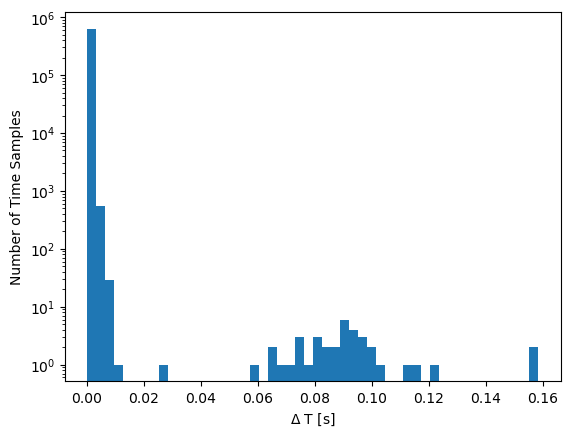

In [421]:
plt.hist(np.diff(np.array(f['Acquisition/Raw[0]/RawDataTime']))/1e6, bins=50)
plt.yscale('log')
plt.ylabel('Number of Time Samples')
plt.xlabel(r'$\Delta$ T [s]')

In [270]:
# fill data gaps with NaN values
data = np.array(f['Acquisition/Raw[0]/RawData'])
t_rec = np.array(f['Acquisition/Raw[0]/RawDataTime'])
dt_eq = 1/attrs['PulseRate']*1e6
t_eq = np.arange(t_rec[0], t_rec[-1]+dt_eq, dt_eq)
t_new = np.full(len(t_eq), np.nan)
arr_new = np.full((len(t_eq),data.shape[1]), np.nan)

i=0
for t_rec_idx in range(len(t_rec)):   
    while t_rec[t_rec_idx] > t_eq[i]:
        i+=1
    t_new[i] = t_rec[t_rec_idx]
    arr_new[i] = data[t_rec_idx,:]
data = arr_new #override the data array
times = sintela_to_datetime(t_eq) #override the times array

In [271]:
nt = data.shape[0]
nx = data.shape[1]
print(f'Number of time steps: {nt}, Number of channels: {nx}')
print (f"Nyquist Frequency: {attrs['MaximumFrequency']} Hz, cable length: {attrs['SpatialSamplingInterval']*nx} m")

Number of time steps: 777737, Number of channels: 391
Nyquist Frequency: 10000.0 Hz, cable length: 623.7381104724582 m


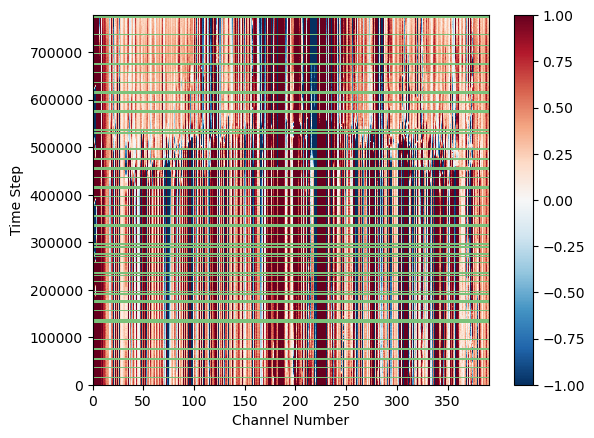

In [272]:
# plot the raw data that was read
import matplotlib
fig, ax = plt.subplots()
cmap = matplotlib.cm.RdBu_r
data_view = data.copy()
data_view[np.isnan(data)]= -99999
cmap.set_bad('C2',-99999)
im = ax.imshow(data,
           aspect='auto',vmin=-1,vmax=1,
           extent=[0,nx,0,nt],
           cmap=cmap,
              interpolation='none'
              )
cbar = plt.colorbar(im)
plt.xlabel('Channel Number')
plt.ylabel('Time Step')
plt.show()

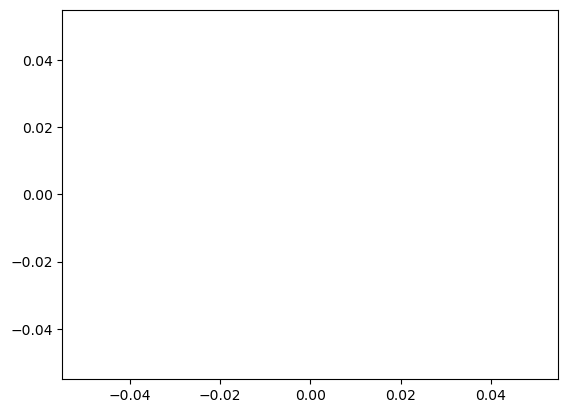

In [273]:
[b,a]=butter(2, 10,'highpass', fs=attrs['PulseRate']) # frequency in m
data_filt = filtfilt(b,a,data,axis=0)
plt.plot(data_filt[0:2000,0])

In [294]:
# select channels
start_cha = 0 #800 #350
end_cha = 100#data.shape[1] #500
t_start = 0 #in seconds
t_end = data.shape[0]/attrs['PulseRate']

data_select = data[int(t_start*attrs['PulseRate']):int(t_end*attrs['PulseRate'])
                   ,start_cha:end_cha]
np.shape(data_select)

(777737, 100)

## Histogram of Raw Data

Text(0.5, 0, 'Raw Phase (selected data)')

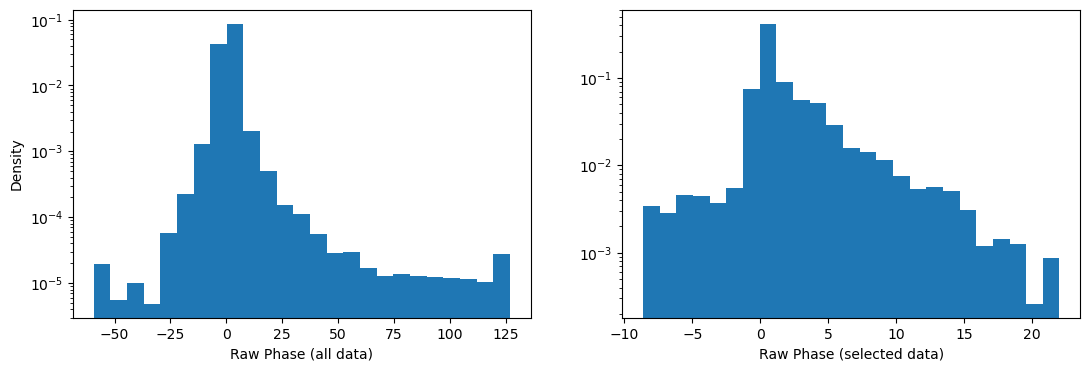

In [275]:
# plot distribution of raw phase. Should be between -1 and +1
fig, ax = plt.subplots(1,2, figsize=(13,4))
ax[0].hist(data.flatten(), bins=25, density=True)
ax[1].hist(data_select.flatten(), bins=25, density=True)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Raw Phase (all data)')
ax[1].set_xlabel('Raw Phase (selected data)')

In [295]:
# normalize each channel by the maximum amplitude
data_norm = data_select.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm /= np.max(np.abs(data_norm[~np.isnan(data_norm)]), axis=0)

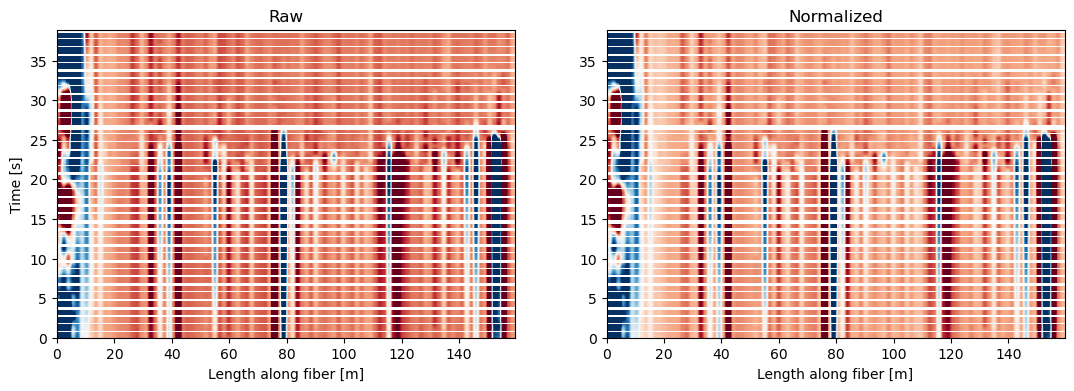

In [296]:
# plot the selected and filtered data
fig, ax = plt.subplots(1,2, figsize=(13,4))
ax[0].imshow(data_select-np.median(data_select[~np.isnan(data_select)]),
           aspect='auto',vmin=np.percentile(data_select[~np.isnan(data_select)],5),
             vmax=np.percentile(data_select[~np.isnan(data_select)],95),
           extent=[start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval'],
                   t_start,t_end],
            cmap='RdBu')
ax[1].imshow(data_norm,
           aspect='auto',vmin=np.percentile(data_norm[~np.isnan(data_norm)],5),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],95),
           extent=[start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval'],
                   t_start,t_end],
            cmap='RdBu')
ax[0].set_title('Raw')
ax[1].set_title('Normalized')
ax[0].set_xlabel('Length along fiber [m]')
ax[1].set_xlabel('Length along fiber [m]')
ax[0].set_ylabel('Time [s]')
plt.show()

In [297]:
#implement filtering on sections of data between data gaps

In [118]:
from scipy.signal import butter, filtfilt

# filter in time
[b,a]=butter(2, 1,'highpass', fs=attrs['PulseRate']) # frequency in m
data_filt = filtfilt(b,a,data_select,axis=0)

# bandpass in time
# [b,a]=butter(2, [100,300],'bandpass', fs=attrs['PulseRate']) # frequency in m
# data_filt = filtfilt(b,a,data_select,axis=0)

# filter in space
# [b,a]=butter(2, 1/(attrs['GaugeLength']*5),'lowpass', fs=1/attrs['SpatialSamplingInterval']) # corner in 1 over meter
# data_filt = filtfilt(b,a,data_filt,axis=1)

In [303]:
# normalize each channel by the maximum amplitude
data_norm = data_select.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm /= np.max(np.abs(data_norm[~np.isnan(data_norm)]), axis=0)

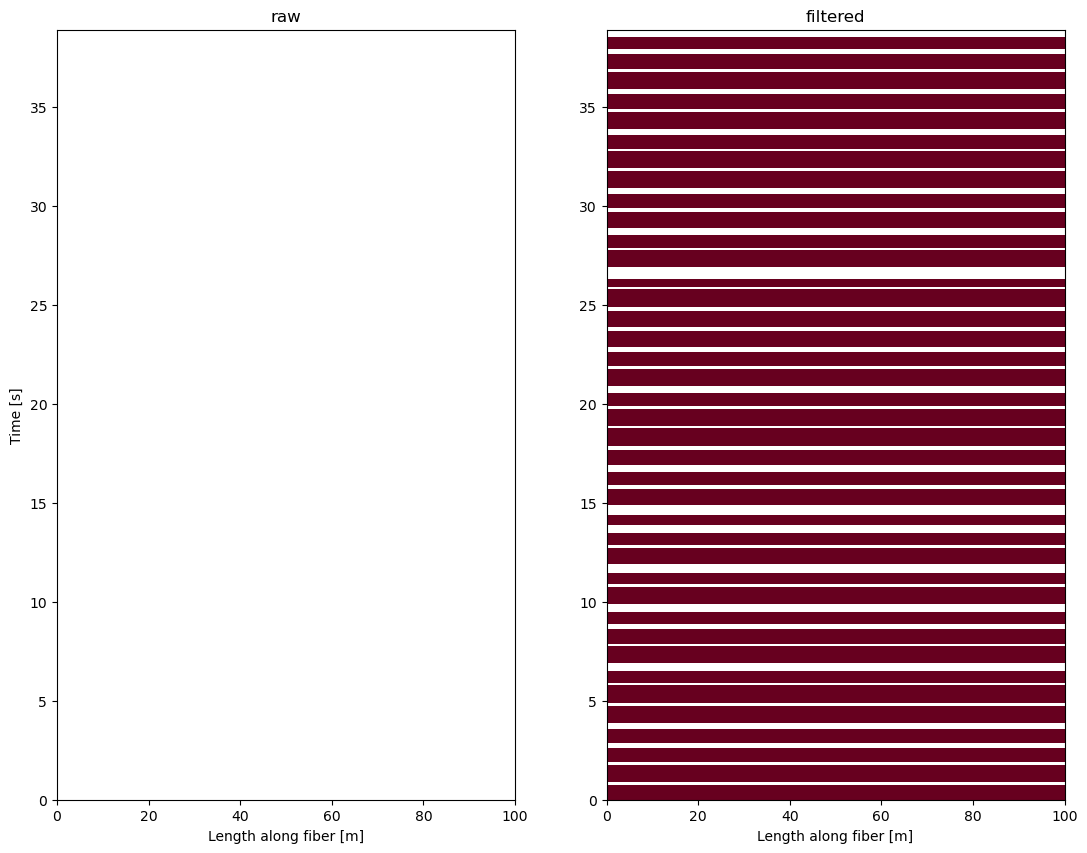

In [302]:
# plot the selected and filtered data
fig, ax = plt.subplots(1,2, figsize=(13,10))
ax[0].imshow(data_select-np.median(data_select),
           aspect='auto',vmin=np.percentile(data_select,5),vmax=np.percentile(data_select,95),
           extent=[start_cha,
                   end_cha,
                   t_start,t_end],
            cmap='RdBu')
ax[1].imshow(data_norm,
           aspect='auto',
            vmin=np.percentile(data_norm,5),vmax=np.percentile(data_norm,95),
           extent=[start_cha,
                   end_cha,
                   t_start,t_end],
             cmap='RdBu',
#             interpolation='none'
            )
ax[0].set_title('raw')
ax[1].set_title('filtered')
ax[0].set_xlabel('Length along fiber [m]')
ax[1].set_xlabel('Length along fiber [m]')
ax[0].set_ylabel('Time [s]')
plt.show()

Text(0, 0.5, 'Channel #')

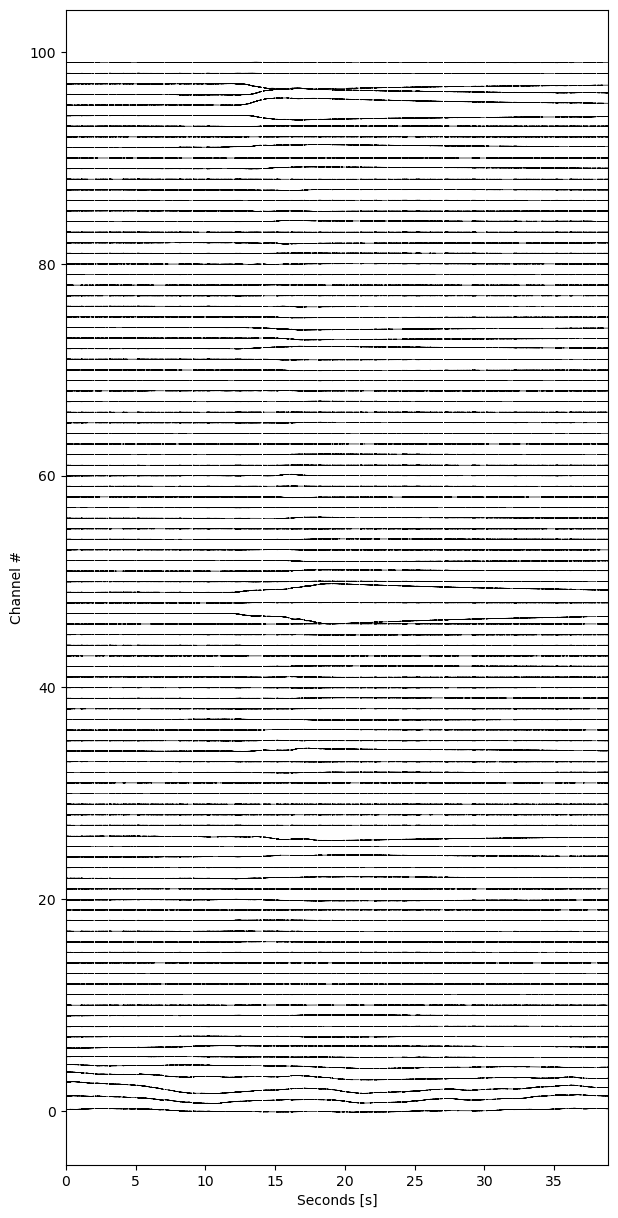

In [304]:
# bandpass in time
# [b,a]=butter(2, [100,300],'bandpass', fs=attrs['PulseRate']) # frequency in m
# data_filt = filtfilt(b,a,data_select,axis=0)

# normalize each channel by the maximum amplitude
data_norm = data_select.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm /= np.max(np.abs(data_norm[~np.isnan(data_norm)]), axis=0)

fig = plt.figure(figsize=(7,15))
for i in range(0, np.shape(data_select)[1], 1):
    plt.plot(np.arange(t_start,t_end,1/attrs['PulseRate']), 
             start_cha+i+data_norm[:,i], color='k', alpha=1, linewidth=0.5)
plt.xlim(t_start, t_end)
plt.xlabel('Seconds [s]')
plt.ylabel('Channel #')

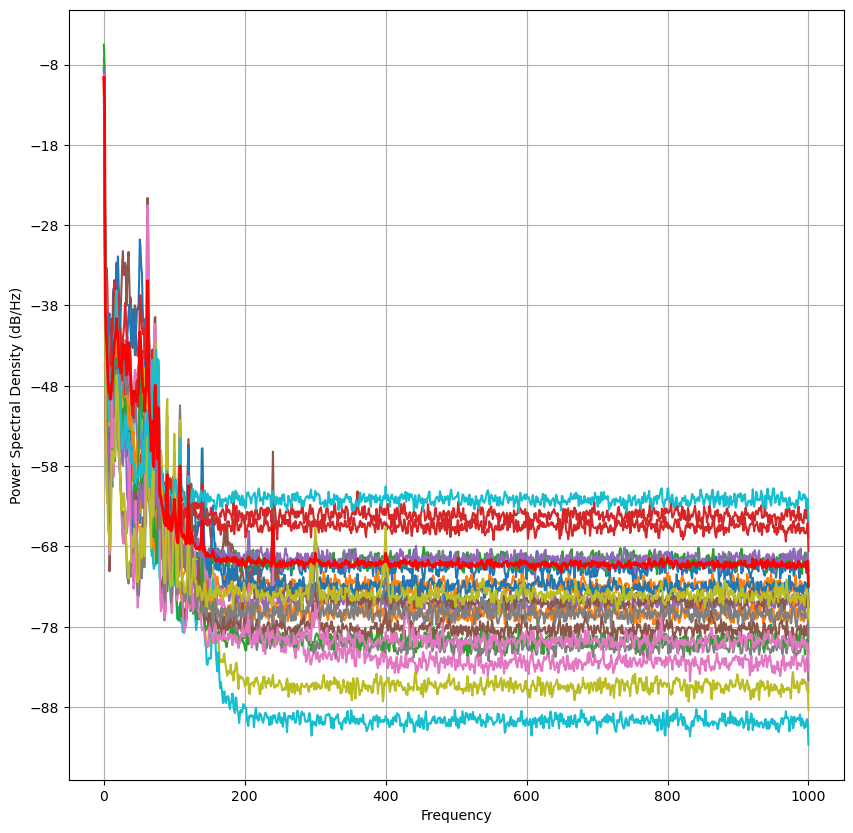

In [102]:
# periodogram

data_norm = data_select.copy()
data_norm -= np.mean(data_norm, axis=0)
data_norm /= np.max(np.abs(data_norm), axis=0)

fig, ax = plt.subplots(figsize=(10,10))
for i in range(np.shape(data_norm)[1]):
    Pxx, freqs = plt.psd(data_norm[:,i], Fs=attrs['PulseRate'], NFFT=int(attrs['PulseRate']*1))
    if i==0:
        Pxx_all = np.full([np.shape(data_norm)[1],len(Pxx)], np.nan)
    Pxx_all[i] = Pxx
    
plt.plot(freqs, 10*np.log10(np.mean(Pxx_all, axis=0)), color='r', linewidth=2)
# plt.xscale('log')
# plt.xlim(0,50)


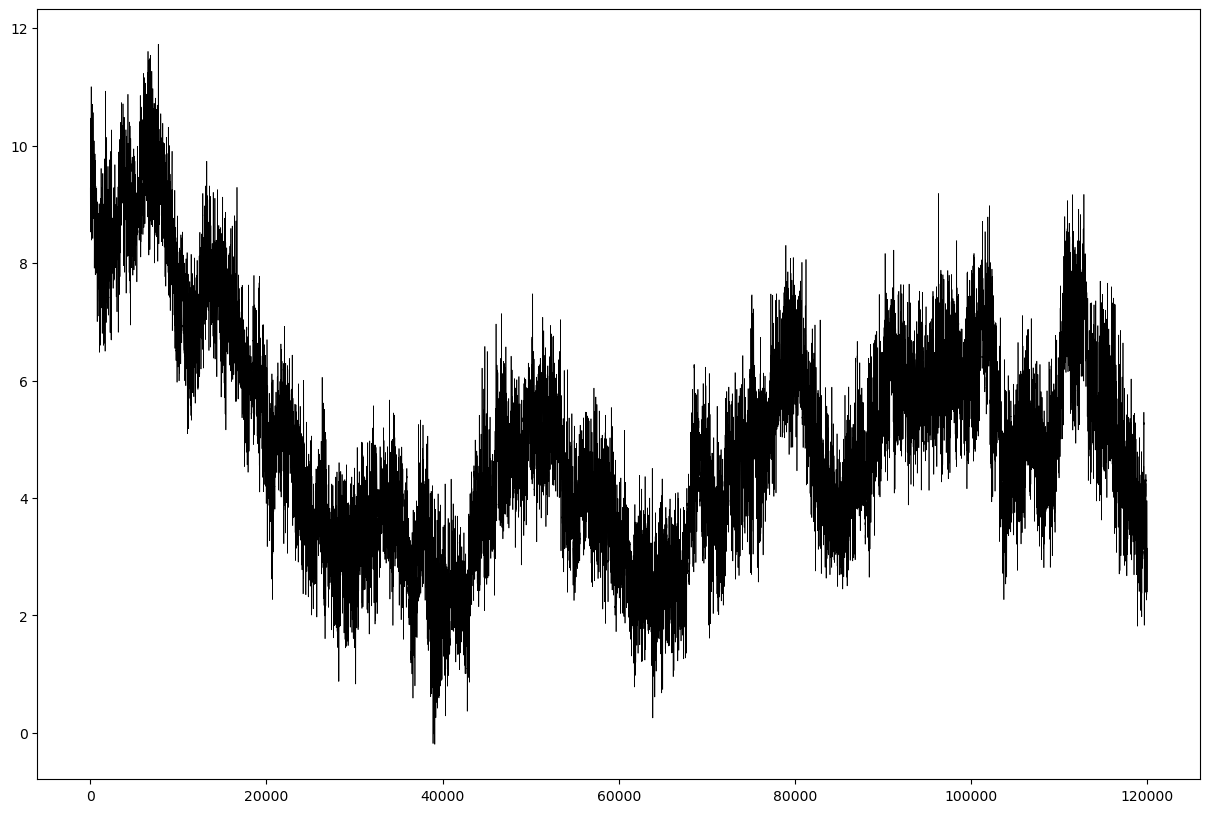

In [103]:
# make this a spaghetti plot with the mean as a thick line
fig = plt.figure(figsize=(15,10))
plt.plot(start_cha+i+data_select[0:500000,10], color='k', alpha=1, linewidth=0.5)

Text(0.5, 0, 'Time [s]')

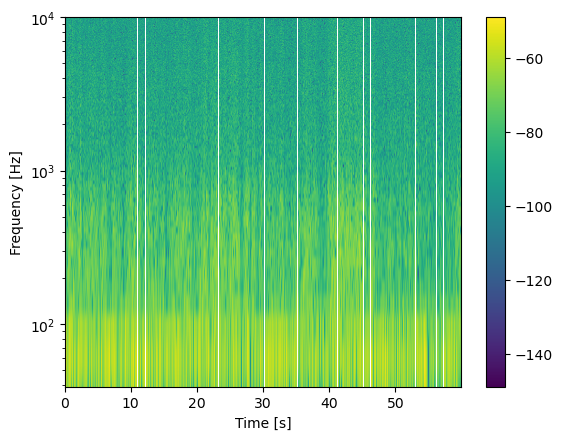

In [222]:
# plot a spectrogram
spec_data = np.mean(data, axis=1)
# spec_data = data[:,100]
fs = attrs['PulseRate'] #sampling rate
NFFT =512
Pxx, freqs, bins, im = plt.specgram(spec_data, 
                                    Fs=fs,
                                    NFFT=NFFT,
                                    noverlap=0,
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',
                                    # vmax=-40, vmin=-80
                                   )
plt.colorbar()
# plt.yscale('log')
plt.ylim(fs/NFFT,fs/2)
plt.yscale('log')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')